In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table
from photutils import RectangularAperture, aperture_photometry
import glob, pdb, mpld3, batman
from mpld3 import plugins
from scipy.optimize import curve_fit

plt.rcParams['figure.figsize'] = (12, 6)
mpld3.enable_notebook()

In [2]:
fnames = np.sort(glob.glob('../hst_archive/*_flt.fits'))
len(fnames)

396

In [3]:
hdu = fits.open(fnames[10])
hdu.info()

Filename: ../hst_archive\ibh717gsq_flt.fits
No.    Name         Type      Cards   Dimensions   Format
  0  PRIMARY     PrimaryHDU     265   ()      
  1  SCI         ImageHDU       140   (128, 128)   float32   
  2  ERR         ImageHDU        51   (128, 128)   float32   
  3  DQ          ImageHDU        43   (128, 128)   int16   
  4  SAMP        ImageHDU        37   (128, 128)   int16   
  5  TIME        ImageHDU        37   (128, 128)   float32   
  6  WCSCORR     BinTableHDU     59   7R x 24C   [40A, I, A, 24A, 24A, 24A, 24A, D, D, D, D, D, D, D, D, 24A, 24A, D, D, D, D, J, 40A, 128A]   


In [4]:
img_list = []
hdr_list = []
for fn in fnames:
    hdu = fits.open(fn)
    header = hdu[0].header
    if header['OBSTYPE'] == 'SPECTROSCOPIC':
        image = hdu[1].data
        img_list.append(image)
        hdr_list.append(header)
    hdu.close()
len(img_list)

392

In [5]:
header

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                   16                                                  
NAXIS   =                    0                                                  
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
ORIGIN  = 'HSTIO/CFITSIO March 2010'                                            
DATE    = '2016-09-15' / date this file was written (yyyy-mm-dd)                
NEXTEND =                    6 / Number of standard extensions                  
FILENAME= 'ibh721riq_flt.fits' / name of file                                   
FILETYPE= 'SCI      '          / type of data found in data file                
                                                                                
TELESCOP= 'HST'             

#### Aperure and BKG sizing

<bound method HDUList.close of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x00000226C2CED588>, <astropy.io.fits.hdu.image.ImageHDU object at 0x00000226B5FBCA20>, <astropy.io.fits.hdu.image.ImageHDU object at 0x00000226C2DDE320>, <astropy.io.fits.hdu.image.ImageHDU object at 0x00000226C2DDEDD8>, <astropy.io.fits.hdu.image.ImageHDU object at 0x00000226C2DE4FD0>, <astropy.io.fits.hdu.image.ImageHDU object at 0x00000226C2DF0898>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x00000226C2DF36A0>]>

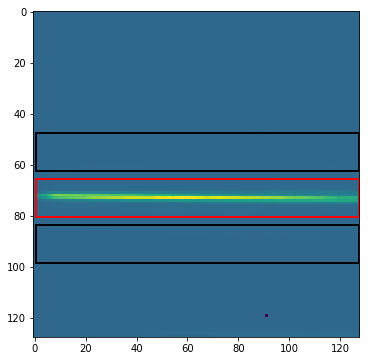

In [6]:
hdu = fits.open(fnames[10])
header = hdu[0].header
data = hdu[1].data
plt.imshow(data)
src_ap = RectangularAperture((64, 73), w = 127, h = 15, theta = 0.0)
bk_ap1 = RectangularAperture((64, 91), w = 127, h = 15, theta = 0.0)
bk_ap2 = RectangularAperture((64, 55), w = 127, h = 15, theta = 0.0)
src_ap.plot(color = 'r', linewidth = 2)
bk_ap1.plot(color = 'k', linewidth = 2)
bk_ap2.plot(color = 'k', linewidth = 2)
hdu.close

In [7]:
flux_table = Table(names = ('time', 'raw_flux', 'bkg_flux', 'res_flux', 'position angle'))
for image, header in zip(img_list, hdr_list):
    mask = np.isnan(image) == True
    time = header['EXPSTART']
    raw_flux = aperture_photometry(image, src_ap, mask = mask)['aperture_sum']
    
    bkg1 = aperture_photometry(image, bk_ap1, mask = mask)['aperture_sum']
    bkg_mean1 = bkg1/bk_ap1.area()
    bkg_flux1 = bkg_mean1*src_ap.area()
    bkg2 = aperture_photometry(image, bk_ap2, mask = mask)['aperture_sum']
    bkg_mean2 = bkg2/bk_ap2.area()
    bkg_flux2 = bkg_mean2*src_ap.area()
    bkg_flux = (bkg_flux1 + bkg_flux2)/2
    
    res_flux = raw_flux - bkg_flux
    
    #pointing information
    pa = header['PA_V3']
    
    flux_table.add_row([time, raw_flux, bkg_flux, res_flux, pa])
flux_table

time,raw_flux,bkg_flux,res_flux,position angle
float64,float64,float64,float64,float64
55949.9071568,184816.664154,4900.70597273,179915.958182,224.535599
55949.9085338,185557.495317,4704.08177525,180853.413541,224.535599
55949.9099112,185666.211319,4488.24693143,181177.964388,224.535599
55949.9112886,185760.402835,4376.53052211,181383.872313,224.535599
55949.912666,185966.138046,4369.55729122,181596.580755,224.535599
55949.9140431,186062.679644,4350.54026832,181712.139376,224.535599
55949.9154205,186104.362587,4319.31196398,181785.050623,224.535599
55949.9167979,186208.061087,4315.64142132,181892.419666,224.535599
55949.9181753,186168.205433,4299.02186604,181869.183566,224.535599


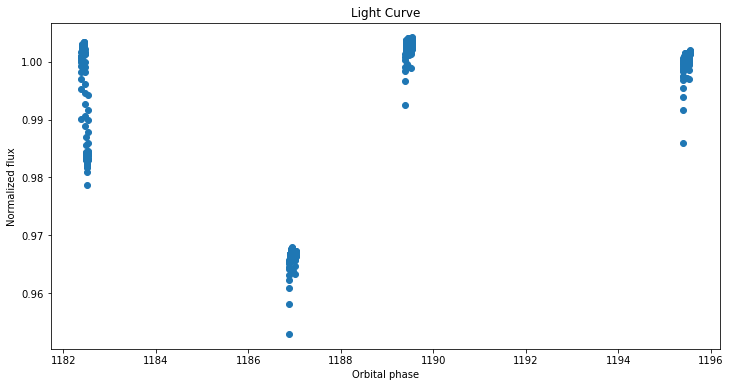

In [8]:
tt        = 2454159.45320
period    = 1.5089557
jd_const  = 2400000.5
norm_flux = flux_table['res_flux']/np.median(flux_table['res_flux'])
op      = np.sort((flux_table['time'] + jd_const - tt)/period)
ind = np.argsort(flux_table['time'])

fig, ax = plt.subplots()
points = ax.plot(op, norm_flux, 'o')
ax.set_xlabel('Orbital phase')
ax.set_ylabel('Normalized flux')
ax.set_title('Light Curve')

# fig.savefig('Light_Curve.pdf')
plugins.connect(fig, plugins.MousePosition(fontsize=14))
labels = ['{}, {}'.format(i + 1, pa) for i, pa in zip(range(len(op)), flux_table['position angle'][ind])]
tooltip = mpld3.plugins.PointLabelTooltip(points[0], labels=labels)
plugins.connect(fig, tooltip)

**HST Visits**
+ 1st visit = 97 points [0:97]
+ 2nd visit = 97 points [98:195]
+ 3rd visit = 97 points [196:293]
+ 4th visit = 97 points [294:391]

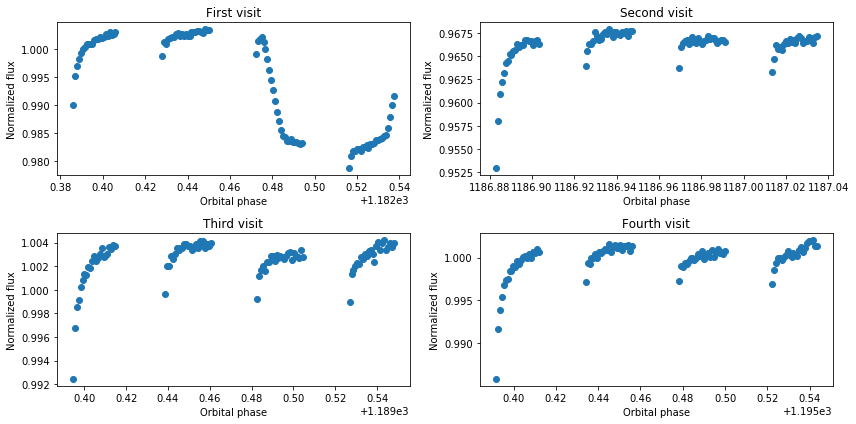

In [9]:
fig, [[ax1, ax2],[ax3, ax4]] = plt.subplots(ncols = 2, nrows = 2)

n = 97
norm_flux = flux_table['res_flux']/np.median(flux_table['res_flux'])
op        = np.sort((flux_table['time'] + jd_const - tt)/period)

points1 = ax1.plot(op[0:97], norm_flux[0:97], 'o')
ax1.set_xlabel('Orbital phase')
ax1.set_ylabel('Normalized flux')
ax1.set_title('First visit')

points2 = ax2.plot(op[98:195], norm_flux[98:195], 'o')
ax2.set_xlabel('Orbital phase')
ax2.set_ylabel('Normalized flux')
ax2.set_title('Second visit')

points3 = ax3.plot(op[196:293], norm_flux[196:293], 'o')
ax3.set_xlabel('Orbital phase')
ax3.set_ylabel('Normalized flux')
ax3.set_title('Third visit')

points4 = ax4.plot(op[294:391], norm_flux[294:391], 'o')
ax4.set_xlabel('Orbital phase')
ax4.set_ylabel('Normalized flux')
ax4.set_title('Fourth visit')

fig.tight_layout()
# fig.savefig('HST_visits.pdf')
plugins.connect(fig, plugins.MousePosition(fontsize=14))
labels = ['point {0}'.format(i + 1) for i in range(n)]
tooltip = mpld3.plugins.PointLabelTooltip(points1[0], labels=labels)
plugins.connect(fig, tooltip)

#### Removing Systematics

**1st HST Visit**
+ 1st orbit = 23 points [0:22]
+ 2nd orbit = 24 points [23:47]
+ 3rd orbit = 24 points [48:72]
+ 4th orbit = 24 points [73:97]

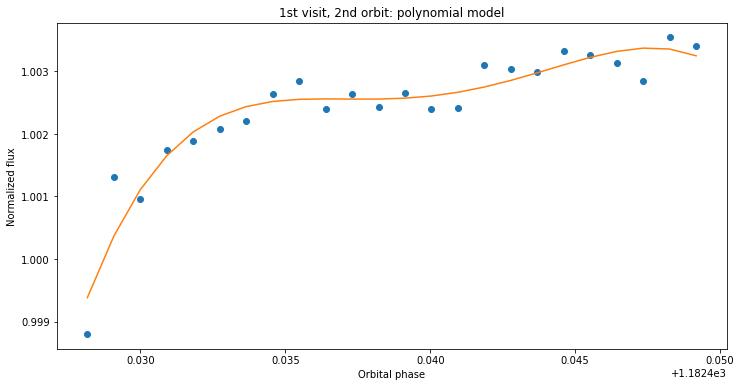

In [62]:
fig, ax = plt.subplots()

op12        = op[23:47]
flux12      = norm_flux[23:47]
poly_params = np.polyfit(op12-op12[0], flux12, 4)
polynomial  = np.poly1d(poly_params)

ax.plot(op12, flux12, 'o')
ax.plot(op12, polynomial(op12-op12[0]))
ax.set_xlabel('Orbital phase')
ax.set_ylabel('Normalized flux')
ax.set_title('1st visit, 2nd orbit: polynomial model')

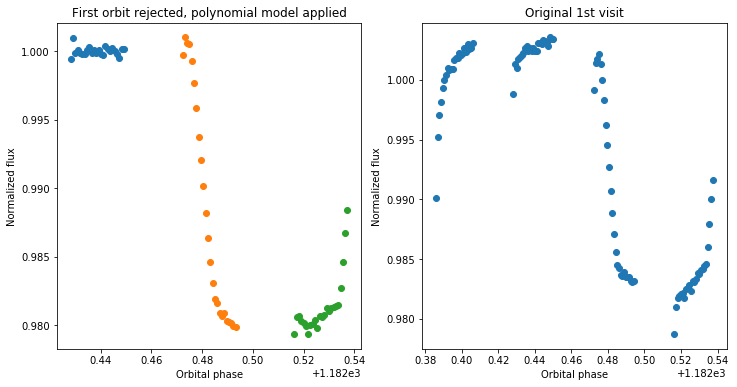

In [63]:
op_v1o2   = op[23:47]
op_v1o3   = op[48:72]
op_v1o4   = op[73:97]
flux_v1o2 = norm_flux[23:47]/polynomial(op_v1o2-op_v1o2[0])
flux_v1o3 = norm_flux[48:72]/polynomial(op_v1o3-op_v1o3[0])
flux_v1o4 = norm_flux[73:97]/polynomial(op_v1o4-op_v1o4[0])

plt.subplot(121)
plt.plot(op_v1o2, flux_v1o2, 'o')
plt.plot(op_v1o3, flux_v1o3, 'o')
plt.plot(op_v1o4, flux_v1o4, 'o')
plt.xlabel('Orbital phase')
plt.ylabel('Normalized flux')
plt.title('First orbit rejected, polynomial model applied')

plt.subplot(122)
plt.plot(op[0:97], norm_flux[0:97], 'o')
plt.xlabel('Orbital phase')
plt.ylabel('Normalized flux')
plt.title('Original 1st visit')

[  1.00298700e+00   3.31799678e+02   1.70003671e-02]


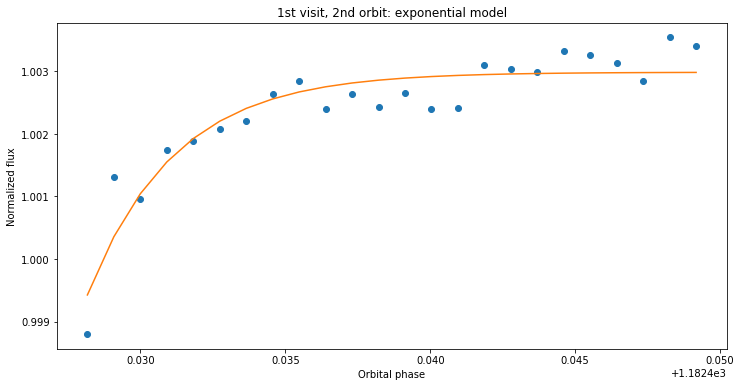

In [83]:
def f(x, a, b, c):
    val = a*(1 - np.exp(-b*(x+c)))
    return val
param, _ = curve_fit(f, op12-op12[0], flux12, p0=(1, (1.5*24*60)/10, 0))

print(param)
fig, ax = plt.subplots()
ax.plot(op12, flux12, 'o')
ax.plot(op12, f(op12-op12[0], *param))
# pdb.set_trace()
ax.set_xlabel('Orbital phase')
ax.set_ylabel('Normalized flux')
ax.set_title('1st visit, 2nd orbit: exponential model')
# fig.savefig('exponential_model.pdf')

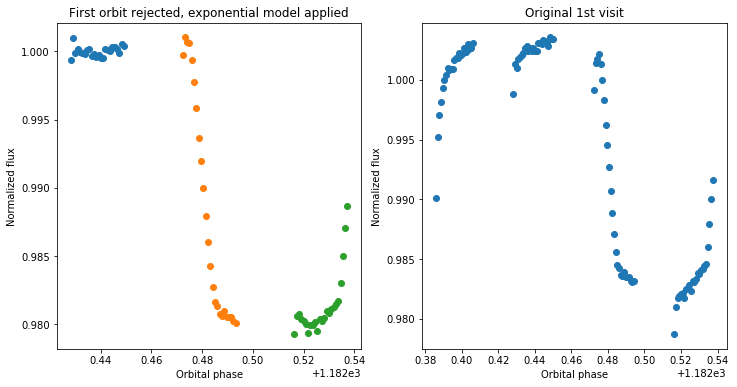

In [85]:
op_v1o2   = op[23:47]
op_v1o3   = op[48:72]
op_v1o4   = op[73:97]
flux_v1o2 = norm_flux[23:47]/f(op_v1o2 - op_v1o2[0], *param)
flux_v1o3 = norm_flux[48:72]/f(op_v1o3 - op_v1o3[0], *param)
flux_v1o4 = norm_flux[73:97]/f(op_v1o4 - op_v1o4[0], *param)

plt.subplot(121)
plt.plot(op_v1o2, flux_v1o2, 'o')
plt.plot(op_v1o3, flux_v1o3, 'o')
plt.plot(op_v1o4, flux_v1o4, 'o')
plt.xlabel('Orbital phase')
plt.ylabel('Normalized flux')
plt.title('First orbit rejected, exponential model applied')

plt.subplot(122)
plt.plot(op[0:97], norm_flux[0:97], 'o')
plt.xlabel('Orbital phase')
plt.ylabel('Normalized flux')
plt.title('Original 1st visit')

**2nd HST Visit**
+ 1st orbit = 22 points [98:120]
+ 2nd orbit = 24 points [121:145]
+ 3rd orbit = 24 points [146:170]
+ 4th orbit = 24 points [171:195]

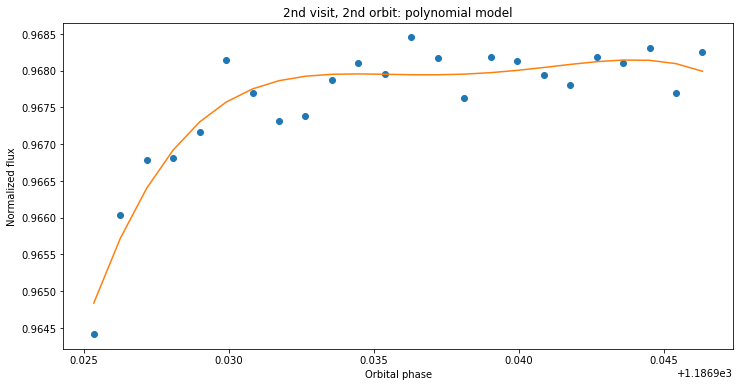

In [66]:
fig, ax = plt.subplots()

op22        = op[121:145]
flux22      = norm_flux[121:145]
poly_params = np.polyfit(op22-op22[0], flux22, 4)
polynomial  = np.poly1d(poly_params)

ax.plot(op22, flux22, 'o')
ax.plot(op22, polynomial(op22-op22[0]))
ax.set_xlabel('Orbital phase')
ax.set_ylabel('Normalized flux')
ax.set_title('2nd visit, 2nd orbit: polynomial model')

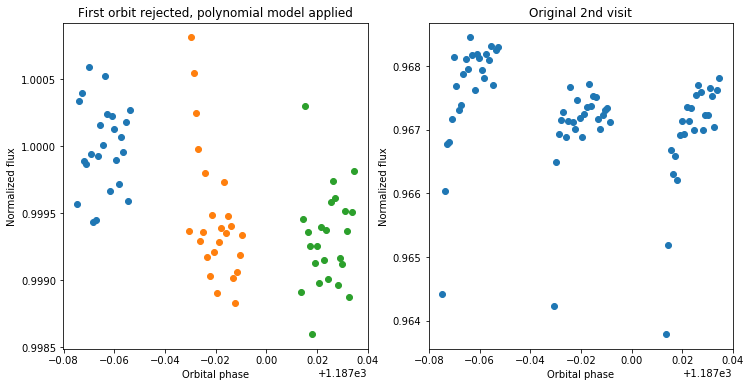

In [67]:
op_v2o2   = op[121:145]
op_v2o3   = op[146:170]
op_v2o4   = op[171:195]
flux_v2o2 = norm_flux[121:145]/polynomial(op_v2o2-op_v2o2[0])
flux_v2o3 = norm_flux[146:170]/polynomial(op_v2o3-op_v2o3[0])
flux_v2o4 = norm_flux[171:195]/polynomial(op_v2o4-op_v2o4[0])

plt.subplot(121)
plt.plot(op_v2o2, flux_v2o2, 'o')
plt.plot(op_v2o3, flux_v2o3, 'o')
plt.plot(op_v2o4, flux_v2o4, 'o')
plt.xlabel('Orbital phase')
plt.ylabel('Normalized flux')
plt.title('First orbit rejected, polynomial model applied')

plt.subplot(122)
plt.plot(op[121:195], norm_flux[121:195], 'o')
plt.xlabel('Orbital phase')
plt.ylabel('Normalized flux')
plt.title('Original 2nd visit')

[  9.68022221e-01   4.63384870e+02   1.21798257e-02]


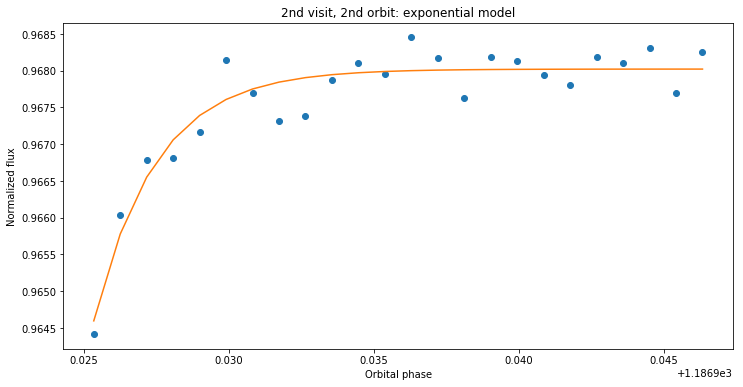

In [68]:
def f(x, a, b, c):
    x0 = op22[0]
    val = a*(1 - np.exp(-b*(x-x0+c)))
    return val
param, _ = curve_fit(f, op22, flux22, p0=(1, (1.5*24*60)/10, 0))

print(param)
fig, ax = plt.subplots()
ax.plot(op22, flux22, 'o')
ax.plot(op22, f(op22, *param))
# pdb.set_trace()
ax.set_xlabel('Orbital phase')
ax.set_ylabel('Normalized flux')
ax.set_title('2nd visit, 2nd orbit: exponential model')
# fig.savefig('exponential_model.pdf')

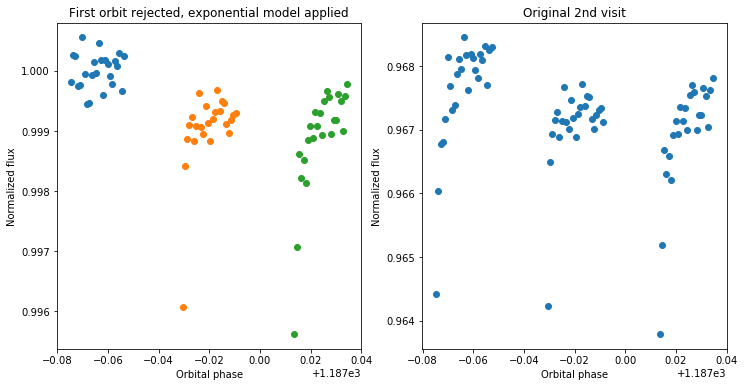

In [69]:
op_v2o2   = op[121:145]
op_v2o3   = op[146:170]
op_v2o4   = op[171:195]
flux_v2o2 = norm_flux[121:145]/f(op_v2o2, *param)
flux_v2o3 = norm_flux[146:170]/f(op_v2o3, *param)
flux_v2o4 = norm_flux[171:195]/f(op_v2o4, *param)


plt.subplot(121)
plt.plot(op_v2o2, flux_v2o2, 'o')
plt.plot(op_v2o3, flux_v2o3, 'o')
plt.plot(op_v2o4, flux_v2o4, 'o')
plt.xlabel('Orbital phase')
plt.ylabel('Normalized flux')
plt.title('First orbit rejected, exponential model applied')

plt.subplot(122)
plt.plot(op[121:195], norm_flux[121:195], 'o')
plt.xlabel('Orbital phase')
plt.ylabel('Normalized flux')
plt.title('Original 2nd visit')

**3rd HST Visit**
+ 1st orbit = 22 points [196:218]
+ 2nd orbit = 24 points [219:243]
+ 3rd orbit = 24 points [244:268]
+ 4th orbit = 24 points [269:293]

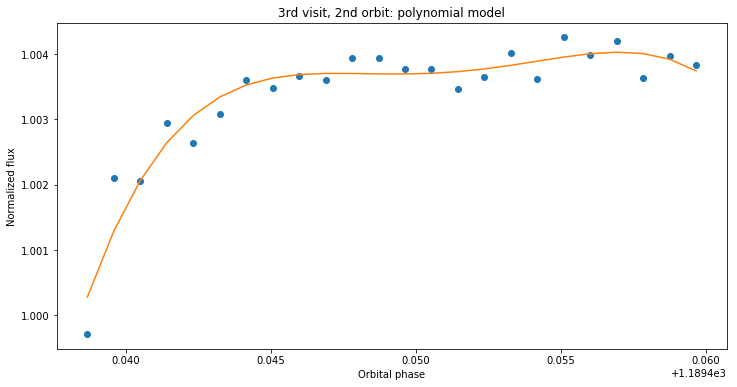

In [70]:
fig, ax = plt.subplots()

op32        = op[219:243]
flux32      = norm_flux[219:243]
poly_params = np.polyfit(op32-op32[0], flux32, 4)
polynomial  = np.poly1d(poly_params)

ax.plot(op32, flux32, 'o')
ax.plot(op32, polynomial(op32-op32[0]))
ax.set_xlabel('Orbital phase')
ax.set_ylabel('Normalized flux')
ax.set_title('3rd visit, 2nd orbit: polynomial model')

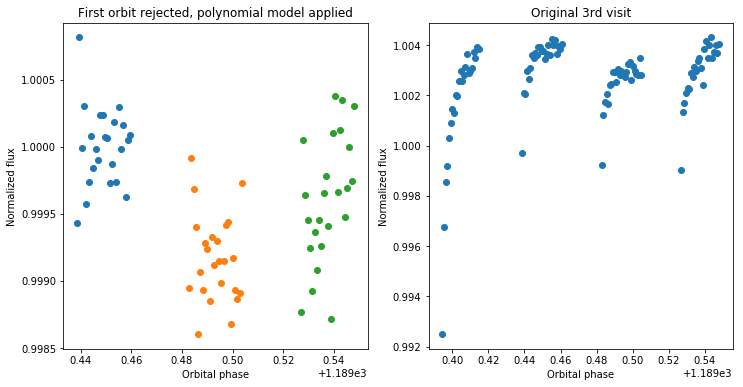

In [71]:
op_v3o2   = op[219:243]
op_v3o3   = op[244:268]
op_v3o4   = op[269:293]
flux_v3o2 = norm_flux[219:243]/polynomial(op_v3o2-op_v3o2[0])
flux_v3o3 = norm_flux[244:268]/polynomial(op_v3o3-op_v3o3[0])
flux_v3o4 = norm_flux[269:293]/polynomial(op_v3o4-op_v3o4[0])

plt.subplot(121)
plt.plot(op_v3o2, flux_v3o2, 'o')
plt.plot(op_v3o3, flux_v3o3, 'o')
plt.plot(op_v3o4, flux_v3o4, 'o')
plt.xlabel('Orbital phase')
plt.ylabel('Normalized flux')
plt.title('First orbit rejected, polynomial model applied')

plt.subplot(122)
plt.plot(op[196:293], norm_flux[196:293], 'o')
plt.xlabel('Orbital phase')
plt.ylabel('Normalized flux')
plt.title('Original 3rd visit')

[  1.00383435e+00   4.49026736e+02   1.24541788e-02]


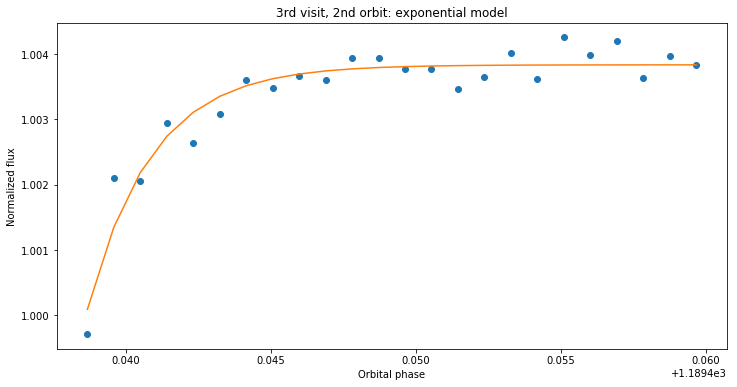

In [72]:
def f(x, a, b, c):
    x0 = op32[0]
    val = a*(1 - np.exp(-b*(x-x0+c)))
    return val
param, _ = curve_fit(f, op32, flux32, p0=(1, (1.5*24*60)/10, 0))

print(param)
fig, ax = plt.subplots()
ax.plot(op32, flux32, 'o')
ax.plot(op32, f(op32, *param))
# pdb.set_trace()
ax.set_xlabel('Orbital phase')
ax.set_ylabel('Normalized flux')
ax.set_title('3rd visit, 2nd orbit: exponential model')
# fig.savefig('exponential_model.pdf')

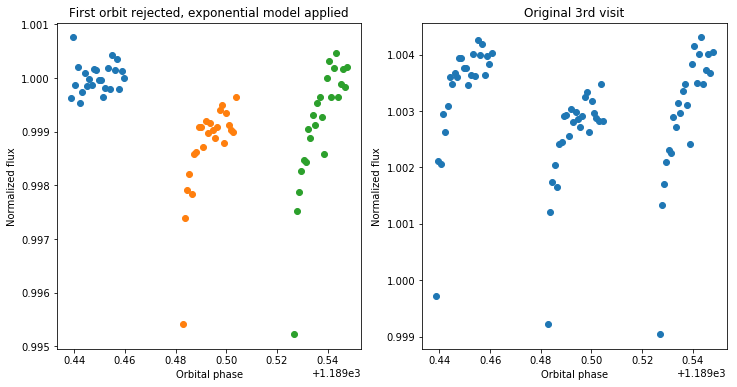

In [73]:
op_v3o2   = op[219:243]
op_v3o3   = op[244:268]
op_v3o4   = op[269:293]
flux_v3o2 = norm_flux[219:243]/f(op_v3o2, *param)
flux_v3o3 = norm_flux[244:268]/f(op_v3o3, *param)
flux_v3o4 = norm_flux[269:293]/f(op_v3o4, *param)


plt.subplot(121)
plt.plot(op_v3o2, flux_v3o2, 'o')
plt.plot(op_v3o3, flux_v3o3, 'o')
plt.plot(op_v3o4, flux_v3o4, 'o')
plt.xlabel('Orbital phase')
plt.ylabel('Normalized flux')
plt.title('First orbit rejected, exponential model applied')

plt.subplot(122)
plt.plot(op[219:293], norm_flux[219:293], 'o')
plt.xlabel('Orbital phase')
plt.ylabel('Normalized flux')
plt.title('Original 3rd visit')

**4th HST Visit**
+ 1st orbit = 22 points [294:316]
+ 2nd orbit = 24 points [317:341]
+ 3rd orbit = 24 points [342:366]
+ 4th orbit = 24 points [367:391]

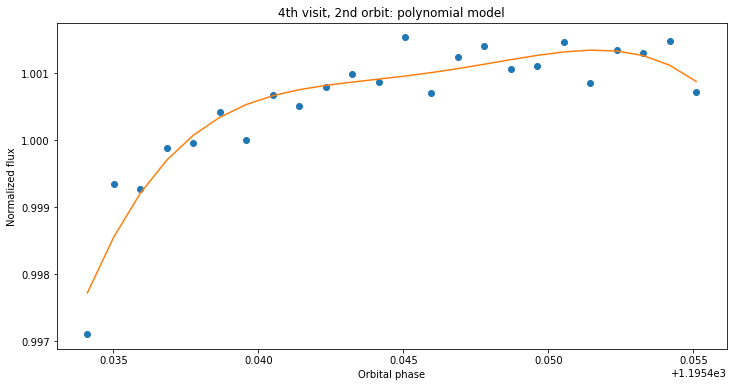

In [74]:
fig, ax = plt.subplots()

op42        = op[317:341]
flux42      = norm_flux[317:341]
poly_params = np.polyfit(op42-op42[0], flux42, 4)
polynomial  = np.poly1d(poly_params)

ax.plot(op42, flux42, 'o')
ax.plot(op42, polynomial(op42-op42[0]))
ax.set_xlabel('Orbital phase')
ax.set_ylabel('Normalized flux')
ax.set_title('4th visit, 2nd orbit: polynomial model')

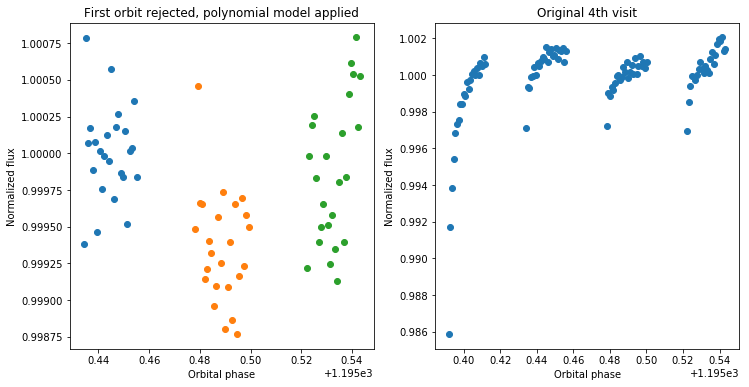

In [75]:
op_v4o2   = op[317:341]
op_v4o3   = op[342:366]
op_v4o4   = op[367:391]
flux_v4o2 = norm_flux[317:341]/polynomial(op_v4o2-op_v4o2[0])
flux_v4o3 = norm_flux[342:366]/polynomial(op_v4o3-op_v4o3[0])
flux_v4o4 = norm_flux[367:391]/polynomial(op_v4o4-op_v4o4[0])

plt.subplot(121)
plt.plot(op_v4o2, flux_v4o2, 'o')
plt.plot(op_v4o3, flux_v4o3, 'o')
plt.plot(op_v4o4, flux_v4o4, 'o')
plt.xlabel('Orbital phase')
plt.ylabel('Normalized flux')
plt.title('First orbit rejected, polynomial model applied')

plt.subplot(122)
plt.plot(op[294:391], norm_flux[294:391], 'o')
plt.xlabel('Orbital phase')
plt.ylabel('Normalized flux')
plt.title('Original 4th visit')

[  1.00116015e+00   3.22110767e+02   1.75540171e-02]


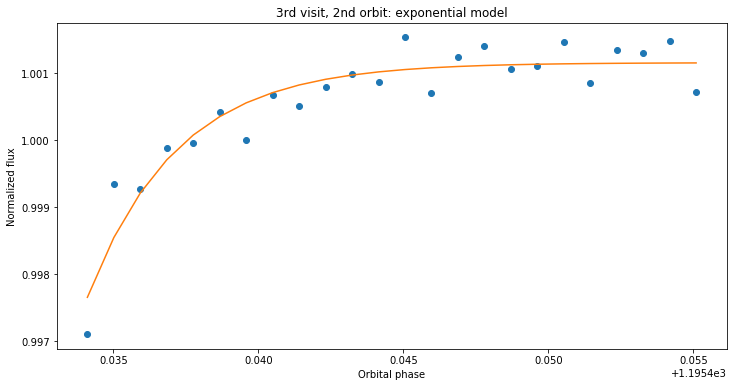

In [76]:
def f(x, a, b, c):
    x0 = op42[0]
    val = a*(1 - np.exp(-b*(x-x0+c)))
    return val
param, _ = curve_fit(f, op42, flux42, p0=(1, (1.5*24*60)/10, 0))

print(param)
fig, ax = plt.subplots()
ax.plot(op42, flux42, 'o')
ax.plot(op42, f(op42, *param))
# pdb.set_trace()
ax.set_xlabel('Orbital phase')
ax.set_ylabel('Normalized flux')
ax.set_title('3rd visit, 2nd orbit: exponential model')
# fig.savefig('exponential_model.pdf')

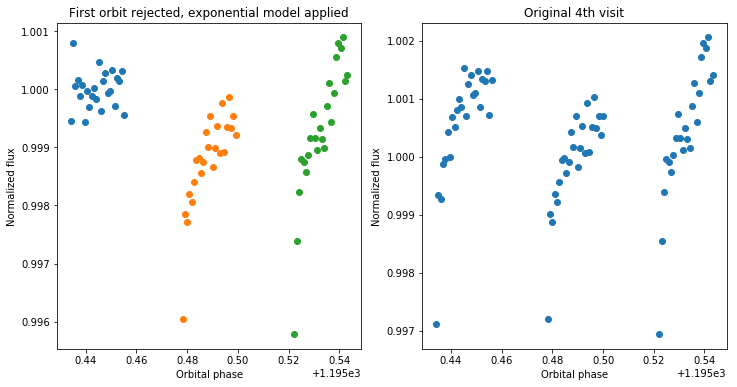

In [77]:
op_v4o2   = op[317:341]
op_v4o3   = op[342:366]
op_v4o4   = op[367:391]
flux_v4o2 = norm_flux[317:341]/f(op_v4o2, *param)
flux_v4o3 = norm_flux[342:366]/f(op_v4o3, *param)
flux_v4o4 = norm_flux[367:391]/f(op_v4o4, *param)


plt.subplot(121)
plt.plot(op_v4o2, flux_v4o2, 'o')
plt.plot(op_v4o3, flux_v4o3, 'o')
plt.plot(op_v4o4, flux_v4o4, 'o')
plt.xlabel('Orbital phase')
plt.ylabel('Normalized flux')
plt.title('First orbit rejected, exponential model applied')

plt.subplot(122)
plt.plot(op[317:391], norm_flux[317:391], 'o')
plt.xlabel('Orbital phase')
plt.ylabel('Normalized flux')
plt.title('Original 4th visit')

#### Background methods

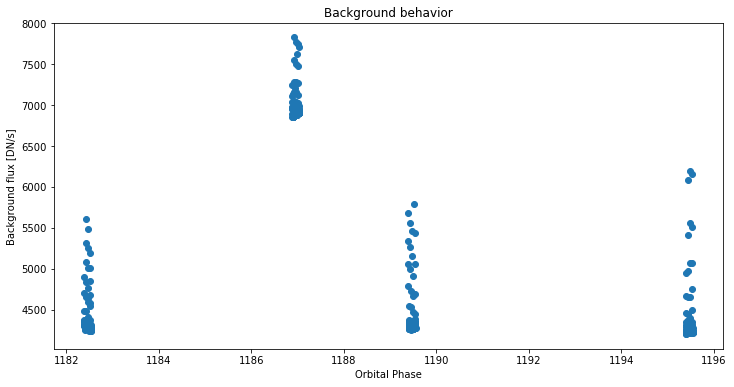

In [19]:
plt.plot(op[ind], flux_table['bkg_flux'][ind], 'o')
plt.title('Background behavior')
plt.xlabel('Orbital Phase')
plt.ylabel('Background flux [DN/s]')

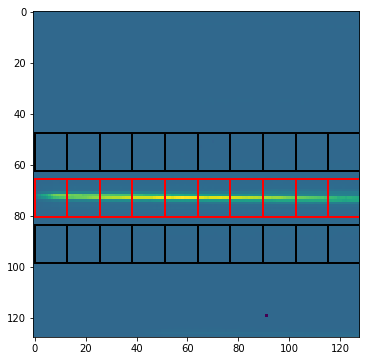

In [20]:
plt.imshow(data)

y_levels = [73, 91, 55]
width    = 128/10.
start    = 0
while (start < (128-width)):
    for y in y_levels:
        x = start + (width/2.)  
        aper = RectangularAperture((x, y), w = width, h = 15, theta = 0.0)
        if y==73 :
            aper.plot(color = 'r', linewidth = 2)
        else:
            aper.plot(color = 'k', linewidth = 2)
    start += width 

In [21]:
y1, y2, y3 = [73, 91, 55]  #spectrum, upper bg, lower bg
width    = 128/10.

col_sub = Table(names = ('time', 'raw_flux', 'bkg_flux', 'res_flux'))
for image, header in zip(img_list, hdr_list):
    mask = np.isnan(image) == True
    time = header['EXPSTART']
    
    raw_flux, bkg_flux, res_flux = 0, 0, 0
    start = 0
    while (start < (128-width)):     #iterating over every box
        x      = start + (width/2.)
        src_ap = RectangularAperture((x, y1), w = width, h = 15, theta = 0.0)
        bk_ap2 = RectangularAperture((x, y2), w = width, h = 15, theta = 0.0)
        bk_ap2 = RectangularAperture((x, y3), w = width, h = 15, theta = 0.0)
    
        raw = aperture_photometry(image, src_ap, mask = mask)['aperture_sum']
        
        bkg1 = aperture_photometry(image, bk_ap1, mask = mask)['aperture_sum']
        bkg_mean1 = bkg1/bk_ap1.area()
        bkg_flux1 = bkg_mean1*src_ap.area()
        
        bkg2 = aperture_photometry(image, bk_ap2, mask = mask)['aperture_sum']
        bkg_mean2 = bkg2/bk_ap2.area()
        bkg_flux2 = bkg_mean2*src_ap.area()
        
        bkg = (bkg_flux1 + bkg_flux2)/2
        res = raw - bkg
        
        start    += width
        raw_flux += raw
        bkg_flux += bkg
        res_flux += res
    
    col_sub.add_row([time, raw_flux, bkg_flux, res_flux])
col_sub

time,raw_flux,bkg_flux,res_flux
float64,float64,float64,float64
55949.9071568,184942.825828,4927.40806246,180015.417766
55949.9085338,185683.857139,4729.49214731,180954.364991
55949.9099112,185790.782361,4512.39474891,181278.387612
55949.9112886,185885.897896,4400.30538929,181485.592507
55949.912666,186093.33923,4393.20971711,181700.129513
55949.9140431,186189.104578,4373.68176043,181815.422818
55949.9154205,186230.867158,4342.7011119,181888.166046
55949.9167979,186334.953824,4338.68631079,181996.267513
55949.9181753,186295.465263,4321.72950651,181973.735757


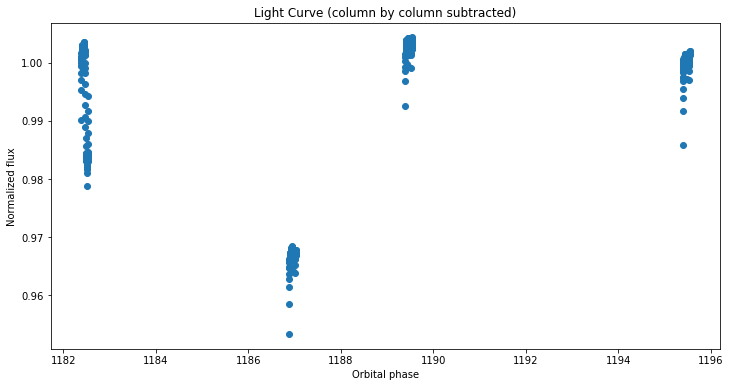

In [22]:
norm_flux = col_sub['res_flux']/np.median(col_sub['res_flux'])
op      = np.sort((col_sub['time'] + jd_const - tt)/period)

fig, ax = plt.subplots()
points = ax.plot(op, norm_flux, 'o')
ax.set_xlabel('Orbital phase')
ax.set_ylabel('Normalized flux')
ax.set_title('Light Curve (column by column subtracted)')

mpld3.plugins.connect(fig, plugins.MousePosition(fontsize=14))
labels = ['%.2f, %.2f' % (x, y) for x, y in zip(op, norm_flux)]
tooltip = mpld3.plugins.PointLabelTooltip(points[0], labels=labels)
mpld3.plugins.connect(fig, tooltip)

In [23]:
y1, y2, y3 = [73, 91, 55]  #spectrum, upper bg, lower bg
width      = 128/10.
flux_array = np.zeros([392, 10]) #392 images, 10 boxes each

for i, (image, header) in enumerate(zip(img_list, hdr_list)):
    
    mask    = np.isnan(image) == True
    counter = 0
    start   = 0
    
    while (start < (128-width)):     #iterating over every box
        x      = start + (width/2.)
        src_ap = RectangularAperture((x, y1), w = width, h = 15, theta = 0.0)
        bk_ap2 = RectangularAperture((x, y2), w = width, h = 15, theta = 0.0)
        bk_ap2 = RectangularAperture((x, y3), w = width, h = 15, theta = 0.0)
    
        raw = aperture_photometry(image, src_ap, mask = mask)['aperture_sum']
        
        bkg1 = aperture_photometry(image, bk_ap1, mask = mask)['aperture_sum']
        bkg_mean1 = bkg1/bk_ap1.area()
        bkg_flux1 = bkg_mean1*src_ap.area()
        
        bkg2 = aperture_photometry(image, bk_ap2, mask = mask)['aperture_sum']
        bkg_mean2 = bkg2/bk_ap2.area()
        bkg_flux2 = bkg_mean2*src_ap.area()
        
        bkg = (bkg_flux1 + bkg_flux2)/2
        res = raw - bkg
        
        flux_array[i][counter] = res
        
        start    += width
        counter  += 1

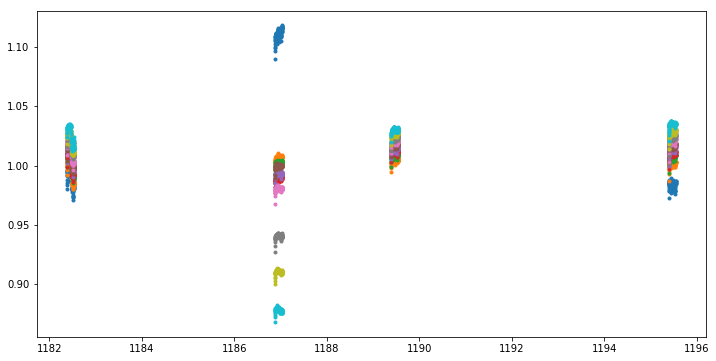

In [24]:
for i in range(10):
    flux = []
    for j in range(392):
        flux.append(flux_array[j][i])
    plt.plot(op, (flux/np.median(flux))+(i/300), '.')

#### Batman model fitting

In [25]:
params = batman.TransitParams()
params.t0        = 2454159.45320            #time of inferior conjunction
params.per       = 1.5089557                    #orbital period
params.rp        = 0.135                    #planet radius (in units of stellar radii)
params.a         = 4.901                    #semi-major axis (in units of stellar radii)
params.inc       = 85.10                    #orbital inclination (in degrees)
params.ecc       = 0.                       #eccentricity
params.w         = 90.                      #longitude of periastron (in degrees)
params.u         = [0.1, 0.3]               #limb darkening coefficients [u1, u2]
params.limb_dark = "quadratic"              #limb darkening model

t = np.linspace(1.4, 1.6, 50)

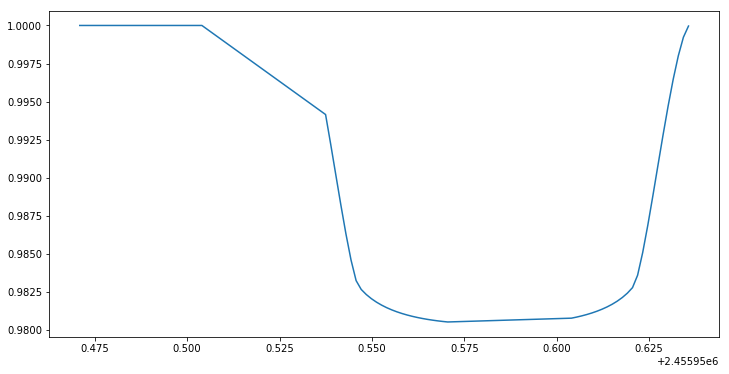

In [26]:
t = col_sub['time'][23:97] + jd_const
m = batman.TransitModel(params, t)    
flux = m.light_curve(params)
plt.plot(t, flux)